# arbitrary rates


In [1]:
import numpy as np
import tensorflow as tf

import os
from itertools import product

from utils import calculate_rate, create_model
from data import create_dataset
from types import SimpleNamespace
import json

RELOAD = False


2022-04-14 10:15:45.127459: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
n_set = np.array([2, 3, 4, 5, 20, 30, 60])
snr_set = np.linspace(-1.5, 5, 14)

experiment_set = np.array(list(product(n_set, snr_set)))

In [3]:
exp = 'arb_rate'
data_dir = '/scratch/users/cmatson/nn-codes/data/'
experiment_dir = os.path.join(data_dir, f'experiment_{exp}')

In [4]:
if RELOAD:
    performance_ber = np.full((len(snr_set), len(n_set)), fill_value=None)
    performance_gp = np.full((len(snr_set), len(n_set)), fill_value=None)
    gap = np.full((len(snr_set), len(n_set)), fill_value=None)

    didnot = []
    for test, (n, snr) in enumerate(experiment_set):
        k, _, r, c = calculate_rate(k=None, n=n, SNR=snr)
        if k==0:
            continue

        if not os.path.exists(os.path.join(experiment_dir, f'test_{test}', 'val_history.npy')):
            print(f' {test} did not complete')
            didnot.append(test)
            continue
        hv = np.load(os.path.join(experiment_dir, f'test_{test}', 'val_history.npy'), allow_pickle=True).item()


        performance_ber[snr_set==snr, n_set==n] = 1-max(hv['binary_accuracy'])
        performance_gp[snr_set==snr, n_set==n] = (k/n)*max(hv['binary_accuracy'])
        gap[snr_set==snr, n_set==n] = c-r

        with open(os.path.join(experiment_dir, f'test_{test}', 'args.json')) as f:
            json_args = json.load(f)

        args = SimpleNamespace(**json_args)


        if False:
            fig, ax = plt.subplots(1,2, tight_layout=True)
            ax[0].plot(hv['loss'], label='loss')
            ax[0].set_title('loss')

            ax[1].plot(hv['binary_accuracy'], label='acc')
            ax[1].set_yscale('log')
            ax[1].set_title('acc')

            fig.suptitle(f'{k}/{n} @ snr {snr:.1f}')


In [5]:
if RELOAD:
    np.save(os.path.join(experiment_dir, 'performance_ber.npy'), performance_ber)
    np.save(os.path.join(experiment_dir, 'performance_gp.npy'), performance_gp)
    np.save(os.path.join(experiment_dir, 'gap.npy'), gap)
    
if not RELOAD:
    performance_ber = np.load(os.path.join(experiment_dir, 'performance_ber.npy'), allow_pickle=True)
    performance_gp = np.load(os.path.join(experiment_dir, 'performance_gp.npy'), allow_pickle=True)
    gap = np.load(os.path.join(experiment_dir, 'gap.npy'), allow_pickle=True)

In [6]:
turboae_13 = np.array([4.1e-2, 3.0e-2, 1e-2, 3.0e-3, 8e-4, 2.5e-4, 7e-5, 3.1e-5, 6e-6, 2e-6])

turboae_12 = np.array([None, None, None, 1.5e-1, None, 7e-2, None,  1e-2, None, 1e-3])

In [7]:
from matplotlib.cm import turbo


import matplotlib.pyplot as plt
PUBLISH=False
if PUBLISH:
    plt.rcParams.update(get_tex_fonts())
    plt.rcParams.update({'figure.figsize':set_size(width='conference', fraction=0.5)})
else:
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'figure.figsize':(6,4)})

%matplotlib inline

In [8]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.grid.which':

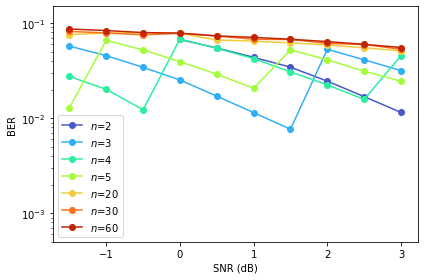

In [12]:
color_idx = np.linspace(.1,.9,len(n_set))

fig, ax = plt.subplots(tight_layout=True)
# fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
for i, n_idx in enumerate([0,1,2,3,4,5,6]):
    ax.plot(snr_set[:-4], performance_ber[:-4,n_idx], 'o-', color=turbo(color_idx[n_idx]), label=f'$n$={n_set[n_idx]}')
ax.set_yscale('log')
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('BER')
ax.set_ylim([.5e-3,.15])
ax.legend(loc='lower left')
if PUBLISH:
    fig.savefig('./figures/ber_vs_snr_each_n.pdf')

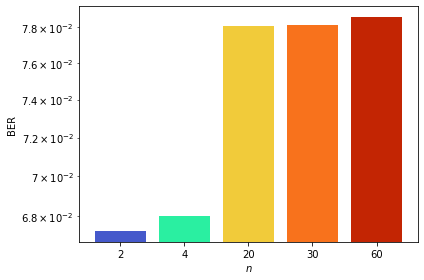

In [45]:
fig, ax = plt.subplots(tight_layout=True)
for i, n_idx in enumerate([0, 2, 4, 5, 6]):
    ax.bar(i,performance_ber[snr_set==0,n_idx], color=turbo(color_idx[n_idx]))
ax.set_xticks(range(5))
ax.set_xticklabels(np.array(n_set)[[0,2,4,5,6]])
ax.set_xlabel('$n$')
ax.set_ylabel('BER')
ax.set_yscale('log')
if PUBLISH:
    fig.savefig('./figures/fixed_gap.pdf')

In [9]:
turboae_13 = np.array([4.1e-2, 3.0e-2, 1e-2, 3.0e-3, 8e-4, 2.5e-4, 7e-5, 3.1e-5, 6e-6, 2e-6])

turboae_12 = np.array([None, None, None, 1.5e-1, None, 7e-2, None,  1e-2, None, 1e-3])

In [10]:
turboae_13_gp = (1/3)*(1-np.array([4.1e-2, 3.0e-2, 1e-2, 3.0e-3, 8e-4, 2.5e-4, 7e-5, 3.1e-5, 6e-6, 2e-6]))

turboae_12_gp = (1/2)*(1-np.array([1.5e-1,  7e-2,  1e-2, 1e-3]))

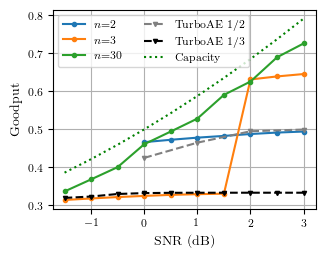

In [13]:
from plotting import get_tex_fonts, set_size
plt.rcParams.update(get_tex_fonts())
fig, ax = plt.subplots(1,1,figsize=set_size(width='conference', fraction=0.47), tight_layout=True)
for i, n_idx in enumerate([0,1,5]):
    ax.plot(snr_set[:-4], performance_gp[:-4,n_idx], 'o-', label=f'$n$={n_set[n_idx]}')

ax.plot(snr_set[3:-4:2], turboae_12_gp, 'v--', color='gray', label='TurboAE 1/2')
ax.plot(snr_set[:-4], turboae_13_gp, 'v--', color='black', label='TurboAE 1/3')
ax.plot(snr_set[:-4], [calculate_rate(k=None, n=30, SNR=snr)[-1] for snr in snr_set[:-4]], 'g:', label='Capacity')
# plt.yscale('log')
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Goodput')
ax.legend(ncol=2)
ax.grid('on')

fig.savefig('./figures/gp_vs_snr_each_n.pdf')

In [17]:
turboae_13_gap = np.array([calculate_rate(k=None, n=3, SNR=snr)[-1] - (1/3) for snr in snr_set[:-4]])
turboae_12_gap = np.array([calculate_rate(k=None, n=2, SNR=snr)[-1] - (1/2) for snr in snr_set[3:-4]])

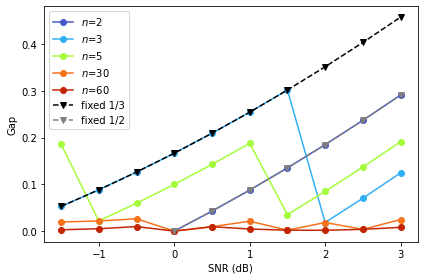

In [19]:
fig, ax = plt.subplots(tight_layout=True)
for i, n_idx in enumerate([0,1,3,5,6]):
    ax.plot(snr_set[:-4], gap[:-4,n_idx], 'o-', color=turbo(color_idx[n_idx]), label=f'$n$={n_set[n_idx]}')
ax.plot(snr_set[:-4], turboae_13_gap, 'v--', color='black', label='fixed 1/3')
ax.plot(snr_set[3:-4], turboae_12_gap, 'v--', color='gray', label='fixed 1/2')
# plt.yscale('log')
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Gap')
ax.legend()
if PUBLISH:
    fig.savefig('./figures/gap_vs_snr_each_n.pdf')

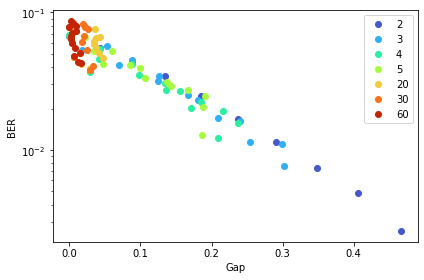

In [50]:
fig, ax = plt.subplots(tight_layout=True)
for i in range(len(n_set)):
    ax.plot(gap[:,i], performance_ber[:, i], 'o', color=turbo(color_idx[i]), label=n_set[i])
ax.set_yscale('log')
ax.set_xlabel('Gap')
ax.set_ylabel('BER')
ax.legend()
if PUBLISH:
    fig.savefig('./figures/ber_vs_gap_each_n.pdf')

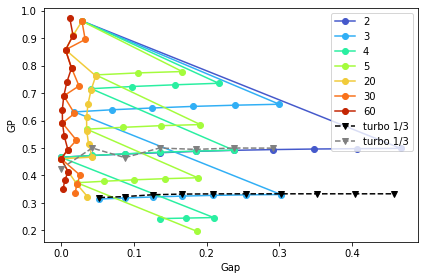

In [51]:
fig, ax = plt.subplots(tight_layout=True)
for i in range(len(n_set)):
    ax.plot(gap[:,i], performance_gp[:,i], 'o-', color=turbo(color_idx[i]), label=n_set[i])
ax.plot(turboae_13_gap, turboae_13_gp, 'v--', color='black', label='turbo 1/3')
ax.plot(turboae_12_gap, turboae_12_gp, 'v--', color='gray', label='turbo 1/3')

ax.set_xlabel('Gap')
ax.set_ylabel('GP')
ax.legend()
if PUBLISH:
    fig.savefig('./figures/gp_vs_gap_each_n.pdf')